In [64]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
class Data:    
    """Подготовка исходных данных"""
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = df[['LifeSquare', "Healthcare_1"]].median()
        
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        
        # 2. Выбросы (outliers)
        df.loc[df["KitchenSquare"] > 40, "KitchenSquare"] = df["KitchenSquare"].median()
        df.loc[df["HouseFloor"] > 50, "HouseFloor"] = df["HouseFloor"].median()
        df.loc[df['LifeSquare'] < 10, "LifeSquare"] = df["LifeSquare"].median()
        
        df.drop(df[(df['LifeSquare'] < 15) & (df['Square'] < 15)].index, inplace=True)
        df.drop(df[df['LifeSquare'] > 1000].index, inplace=True)
        #df.drop(labels=['Id'], axis=1, inplace=True)
        
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'])], axis=1)
        df.drop(labels=["Ecology_2", "Ecology_3", "Shops_2"], axis=1, inplace=True)
        df.drop(labels=['A', 'B'], axis=1, inplace=True)
        
        # 3. Новые фичи (features)
        
        return df

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [8]:
pipe_tr = Data()
pipe_tr.fit(train_df)
train = pipe_tr.transform(train_df)
train.drop(labels=['Id'], axis=1, inplace=True)

pipe_te = Data()
pipe_te.fit(test_df)
test = pipe_te.transform(test_df)
ID = test['Id']
test.drop(labels=['Id'], axis=1, inplace=True)
scaler = StandardScaler()
test_st = scaler.fit_transform(test)

In [10]:
y = train.pop('Price')
X = train

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)

In [12]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, learning_rate=150, random_state=100)

X_train_tsne = tsne.fit_transform(X_train_scaled)

print('До:\t{}'.format(X_train_scaled.shape))
print('После:\t{}'.format(X_train_tsne.shape))

До:	(6999, 15)
После:	(6999, 2)


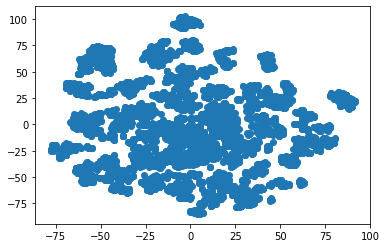

In [15]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

plt.show()

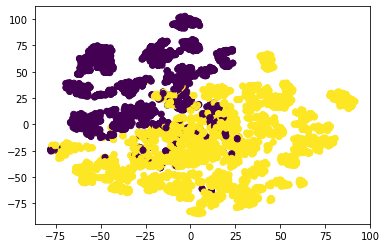

In [54]:
kmeans = KMeans(n_clusters=2)

labels_train = kmeans.fit_predict(X_train_scaled)

plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

plt.show()

In [55]:
labels_test = kmeans.predict(X_test_scaled)

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score

lr = GradientBoostingRegressor()

lr.fit(X_train_scaled, y_train)

y_test_pred = lr.predict(X_test_scaled)

r2_score(y_test, y_test_pred)

0.7085334532492656

In [69]:
model2 = GradientBoostingRegressor(n_estimators=100, min_samples_leaf=20, max_depth=5)
model2.fit(X_train_scaled.loc[labels_train == 0], y_train[labels_train == 0])

y_test_pred_0 = model1.predict(X_test_scaled.loc[labels_test == 0])

r2_score(y_test[labels_test == 0], y_test_pred_0)

0.7644837563068456

In [70]:
model2.fit(X_train_scaled.loc[labels_train == 1], y_train[labels_train == 1])

y_test_pred_1 = lr.predict(X_test_scaled.loc[labels_test == 1])

r2_score(y_test[labels_test == 1], y_test_pred_1)

0.6604973216688712

In [71]:
y_test_all = np.hstack([y_test[labels_test == 0], y_test[labels_test == 1]])
y_test_pred_all = np.hstack([y_test_pred_0, y_test_pred_1])

r2_score(y_test_all, y_test_pred_all)

0.712363733390161

{'max_depth': 5, 'min_samples_leaf': 20, 'n_estimators': 100}